<a href="https://colab.research.google.com/github/AlbertoRoldanSastre/AlbertoRoldanSastre/blob/main/pipeline_YOLOGO_17_4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PIPELINE COMPLETA CHATGPT



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
################################IMPORTAR EL dataset entero a colab UNA VEZ TIENES LA ESTRUCTURA  ####################################################
####################################################################################


# Copiar el archivo data.yaml desde Drive a la ruta deseada en Colab
!cp -r "/content/drive/MyDrive/AWS.v72_seals100i.yolov8" "/content/dataset/"

# Verificar que se copió correctamente
!ls -l "/content/dataset"

total 36
-rw------- 1 root root  249 Apr 17 11:53 data.yaml
-rw------- 1 root root  127 Apr 17 11:53 README.dataset.txt
-rw------- 1 root root  948 Apr 17 11:53 README.roboflow.txt
drwx------ 4 root root 4096 Apr 17 12:03 resulta_1vs_5_lr0,0001
drwx------ 4 root root 4096 Apr 17 11:59 resulta_1vs_5_lr0,0005
drwx------ 4 root root 4096 Apr 17 12:04 resulta_1vs_5_lr0,001
drwx------ 4 root root 4096 Apr 17 11:54 test
drwx------ 4 root root 4096 Apr 17 11:56 train
drwx------ 4 root root 4096 Apr 17 11:58 valid


In [4]:
!pip install opencv-python-headless albumentations

In [5]:
# full_pipeline_colab.py (versión todo-en-uno, sin imports internos)


import os
import cv2
import albumentations as A
import random
import shutil
import numpy as np
import torch  # YOLO de Ultralytics utiliza PyTorch internamente

# Fijar la semilla para reproducibilidad
SEED = 42  # Puedes cambiar este valor a cualquier entero
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ------------------------------------
# CONFIGURACIÓN (editable)
# ------------------------------------
BASE_DATASET_DIR = "/content/dataset"
EXPORT_DIR = "/content/export_yolov8v72_1_vs_5"  # Carpeta destino local (Colab)
IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png")
# Parámetros para tiling

TILE_SIZE = 640               # Por ejemplo, tamaño deseado de cada tile
OVERLAP = 128                 # Overlap en píxeles entre tiles


# Parámetros para el splitting de negativos y augmentación:

NEGATIVE_MULTIPLIER = 5  # si pones : 6--> 1 positiva : 5 negativas (ratio 1/6 total) # Ej: 1 positiva : 10 negativas
AUGMENTATIONS_MIN = 4
AUGMENTATIONS_MAX = 6


# Rutas para el data.yaml:

# Ruta al archivo data.yaml original (de entrada)
INPUT_YAML_PATH = os.path.join(BASE_DATASET_DIR, "data.yaml")              #puede ser : (BASE_DATASET_DIR, "ready", "data.yaml")  si tienes el data yaml dentro de la carpeta base, luego carpeta ready y luedo dta yaml

# Ruta destino dentro del export final
EXPORT_YAML_PATH = os.path.join(EXPORT_DIR, "data.yaml")

# ------------------------------------
# CONTROL DE LIMPIEZA INTERMEDIA
# ------------------------------------
CLEAN_INTERMEDIATE = False  # Elimina carpetas intermedias después del split




# ------------------------------------
# 1. CONVERTIR LABELS: Polígono → Bounding Box
# ------------------------------------
# ------------------------------------
def polygon_to_bbox(coords):
    """
    Convierte una lista de coordenadas de un polígono [x1, y1, x2, y2, ..., xN, yN]
    a una bounding box en formato YOLO: (x_center, y_center, width, height).
    Si la lista de coordenadas está vacía o no tiene un número par de elementos, retorna None.
    """
    if not coords:
        print("Warning: Lista de coordenadas vacía.")
        return None
    if len(coords) % 2 != 0:
        print("Warning: La lista de coordenadas no tiene un número par de elementos.")
        return None
    xs = coords[0::2]
    ys = coords[1::2]
    if not xs or not ys:
        print("Warning: No se pudieron extraer coordenadas X o Y.")
        return None
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    return (x_min + x_max) / 2, (y_min + y_max) / 2, x_max - x_min, y_max - y_min

def process_label_file(src_file, dst_file):
    with open(src_file, 'r') as f_in:
        lines = f_in.readlines()
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        cls = parts[0]
        try:
            coords = list(map(float, parts[1:]))
        except Exception as e:
            print(f"Error en {src_file}: {e}")
            continue
        if len(coords) == 4:
            # Etiqueta ya en formato bbox (x_center, y_center, w, h)
            new_line = f"{cls} {' '.join(f'{c:.16f}' for c in coords)}"
        else:
            bbox = polygon_to_bbox(coords)
            if bbox is None:
                print(f"Warning: No se pudo convertir el polígono en {src_file}. Línea saltada.")
                continue
            x_center, y_center, width, height = bbox
            new_line = f"{cls} {x_center:.16f} {y_center:.16f} {width:.16f} {height:.16f}"
        new_lines.append(new_line)
    with open(dst_file, 'w') as f_out:
        for new_line in new_lines:
            f_out.write(new_line + "\n")

def process_all_labels_for_set(set_name):
    print(f"\n🔄 Convirtiendo etiquetas de {set_name.upper()}...")
    src_dir = os.path.join(BASE_DATASET_DIR, set_name, "labels")
    dst_dir = os.path.join(BASE_DATASET_DIR, set_name, "bblabels")
    os.makedirs(dst_dir, exist_ok=True)
    for filename in os.listdir(src_dir):
        if filename.endswith(".txt"):
            process_label_file(os.path.join(src_dir, filename), os.path.join(dst_dir, filename))
    print(f"✅ [{set_name.upper()}] Conversión de etiquetas completada.")

# ------------------------------------
# 2. TILING y Separación Positivos/Negativos
# ------------------------------------
def load_annotations(label_path, image_width, image_height):
    annotations = []
    if not os.path.exists(label_path):
        return annotations
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cls = parts[0]
            coords = list(map(float, parts[1:]))
            if len(coords) == 4:
                # Se asume formato YOLO: x_center, y_center, w, h (normalizado)
                x_center, y_center, w, h = coords
                x1 = (x_center - w/2) * image_width
                y1 = (y_center - h/2) * image_height
                x2 = (x_center + w/2) * image_width
                y2 = (y_center + h/2) * image_height
            else:
                xs = coords[0::2]
                ys = coords[1::2]
                x1, x2 = min(xs) * image_width, max(xs) * image_width
                y1, y2 = min(ys) * image_height, max(ys) * image_height
            annotations.append((cls, x1, y1, x2, y2))
    return annotations

def adjust_annotation_for_tile(annotation, tile_x, tile_y, tile_size):
    """
    Ajusta una anotación (coordenadas absolutas de la imagen) al sistema de coordenadas locales
    del tile y la normaliza al rango [0,1]. Si la intersección es insuficiente, retorna None.
    """
    cls, x1, y1, x2, y2 = annotation
    # Calcular la intersección entre la caja y el tile
    inter_x1 = max(x1, tile_x)
    inter_y1 = max(y1, tile_y)
    inter_x2 = min(x2, tile_x + tile_size)
    inter_y2 = min(y2, tile_y + tile_size)
    if inter_x2 <= inter_x1 or inter_y2 <= inter_y1:
        return None
    # Coordenadas locales dentro del tile
    local_x1 = inter_x1 - tile_x
    local_y1 = inter_y1 - tile_y
    local_x2 = inter_x2 - tile_x
    local_y2 = inter_y2 - tile_y
    w = local_x2 - local_x1
    h = local_y2 - local_y1
    x_center = local_x1 + w / 2
    y_center = local_y1 + h / 2
    norm_x = x_center / tile_size
    norm_y = y_center / tile_size
    norm_w = w / tile_size
    norm_h = h / tile_size
    # Forzamos que los valores queden en [0,1] (para evitar errores de precisión)
    norm_x = max(0.0, min(1.0, norm_x))
    norm_y = max(0.0, min(1.0, norm_y))
    norm_w = max(0.0, min(1.0, norm_w))
    norm_h = max(0.0, min(1.0, norm_h))
    MIN_SIZE = 0.01
    if norm_w < MIN_SIZE or norm_h < MIN_SIZE:
        return None
    return (cls, norm_x, norm_y, norm_w, norm_h)

def tile_and_separate(image_path, label_path, out_pos_img, out_pos_lbl, out_neg_img, out_neg_lbl, split_name="unknown"):
    image = cv2.imread(image_path)
    if image is None:
        return 0, 0
    orig_h, orig_w = image.shape[:2]
    annotations = load_annotations(label_path, orig_w, orig_h)
    step = TILE_SIZE - OVERLAP
    count_pos, count_neg = 0, 0
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    tile_idx = 0

    # Directorio y archivo de log para tiles descartados
    log_dir = os.path.join(EXPORT_DIR, "errors")
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, "tiles_descartados.txt")
    discard_entries = []

    for y in range(0, orig_h, step):
        for x in range(0, orig_w, step):
            tile = image[y:min(y+TILE_SIZE, orig_h), x:min(x+TILE_SIZE, orig_w)]
            if tile.shape[0] < TILE_SIZE or tile.shape[1] < TILE_SIZE:
                padded = np.zeros((TILE_SIZE, TILE_SIZE, 3), dtype=tile.dtype)
                padded[0:tile.shape[0], 0:tile.shape[1]] = tile
                tile = padded

            tile_name = f"{base_name}_tile_{tile_idx}.jpg"
            label_name = f"{base_name}_tile_{tile_idx}.txt"
            tile_idx += 1

            total_annotations = len(annotations)
            valid_annots = []
            for ann in annotations:
                result = adjust_annotation_for_tile(ann, x, y, TILE_SIZE)
                if result:
                    valid_annots.append(result)

            num_valid = len(valid_annots)
            num_descartadas = total_annotations - num_valid

            if valid_annots:
                cv2.imwrite(os.path.join(out_pos_img, tile_name), tile)
                with open(os.path.join(out_pos_lbl, label_name), 'w') as f:
                    for cls, xc, yc, w, h in valid_annots:
                        f.write(f"{cls} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")
                count_pos += 1
            else:
                #print(f"⚠️ Todas las cajas descartadas en {tile_name} ({num_descartadas}/{total_annotations})")
                cv2.imwrite(os.path.join(out_neg_img, tile_name), tile)
                open(os.path.join(out_neg_lbl, label_name), 'w').close()
                count_neg += 1
                discard_entries.append(
                    f"{tile_name} | de {base_name} @ x={x}, y={y} → {total_annotations} cajas, 0 válidas, {num_descartadas} descartadas"
                )

    if discard_entries:
        with open(log_path, "a") as log:
            log.write(f"\n🔹 DESCARTES EN {split_name.upper()}\n")
            log.write("-" * 50 + "\n")
            for entry in discard_entries:
                log.write(entry + "\n")
            log.write(f"\n🔸 TOTAL TILES DESCARTADOS EN {split_name.upper()}: {len(discard_entries)}\n")

    return count_pos, count_neg

def process_tiling_for_set(set_name):
    print(f"\n📦 Procesando tiling para {set_name.upper()}...")
    input_img_dir = os.path.join(BASE_DATASET_DIR, set_name, "images")
    input_lbl_dir = os.path.join(BASE_DATASET_DIR, set_name, "bblabels")
    pos_img = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "images")
    pos_lbl = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "labels")
    neg_img = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives", "images")
    neg_lbl = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives", "labels")
    os.makedirs(pos_img, exist_ok=True)
    os.makedirs(pos_lbl, exist_ok=True)
    os.makedirs(neg_img, exist_ok=True)
    os.makedirs(neg_lbl, exist_ok=True)

    image_files = [f for f in os.listdir(input_img_dir) if f.lower().endswith(IMAGE_EXTENSIONS)]
    total_pos, total_neg = 0, 0
    for img_file in image_files:
        img_path = os.path.join(input_img_dir, img_file)
        lbl_path = os.path.join(input_lbl_dir, os.path.splitext(img_file)[0] + ".txt")
        pos, neg = tile_and_separate(img_path, lbl_path, pos_img, pos_lbl, neg_img, neg_lbl, split_name=set_name.upper())
        total_pos += pos
        total_neg += neg
    print(f"✅ {set_name.upper()}: {total_pos} tiles positivos, {total_neg} negativos")



# ------------------------------------
# 3. DATA AUGMENTATION (solo positivos de train)
# ------------------------------------


def read_yolo_labels(label_path):
    bboxes, classes = [], []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    classes.append(parts[0])
                    bboxes.append(list(map(float, parts[1:])))
    return bboxes, classes

transform_pipeline = A.Compose([
    A.SomeOf([
        A.HorizontalFlip(p=1.0),
        A.Rotate(limit=(-5, 5), p=1.0),
        A.Affine(shear=(-5, 5), p=1.0),
        A.RandomBrightnessContrast(brightness_limit=(-0.05, 0.05), contrast_limit=(-0.05, 0.05), p=1.0),
        A.Blur(blur_limit=5, p=1.0),
        A.CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
        A.ToGray(p=0.01, num_output_channels=3, method='weighted_average'),
    ], n=4, replace=True),
    A.Resize(TILE_SIZE, TILE_SIZE)
], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

def augment_positives():
    input_img_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "positives", "images")
    input_lbl_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "positives", "labels")
    output_img_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "aug", "positives", "images")
    output_lbl_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "aug", "positives", "labels")
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)
    for filename in os.listdir(input_img_dir):
        if not filename.lower().endswith(IMAGE_EXTENSIONS): continue
        img_path = os.path.join(input_img_dir, filename)
        label_path = os.path.join(input_lbl_dir, os.path.splitext(filename)[0] + ".txt")
        bboxes, classes = read_yolo_labels(label_path)
        if len(bboxes) == 0: continue
        shutil.copy2(img_path, os.path.join(output_img_dir, filename))
        shutil.copy2(label_path, os.path.join(output_lbl_dir, os.path.splitext(filename)[0] + ".txt"))
        num_variants = random.randint(AUGMENTATIONS_MIN, AUGMENTATIONS_MAX)
        for i in range(num_variants):
            image_bgr = cv2.imread(img_path)
            if image_bgr is None: continue
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            try:
                result = transform_pipeline(image=image_rgb, bboxes=bboxes, labels=classes)
            except Exception as e:
                print(f"Error en {filename}: {e}"); continue
            aug_img_rgb = result["image"]
            aug_bboxes = result["bboxes"]
            aug_img_bgr = cv2.cvtColor(aug_img_rgb, cv2.COLOR_RGB2BGR)
            new_img_name = f"{os.path.splitext(filename)[0]}_aug{i}.jpg"
            new_lbl_name = f"{os.path.splitext(filename)[0]}_aug{i}.txt"
            cv2.imwrite(os.path.join(output_img_dir, new_img_name), aug_img_bgr)
            with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
                for cls, bbox in zip(classes, aug_bboxes):
                    f.write(f"{cls} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
    print("✅ Augmentación completada para positivos de TRAIN.")


# ------------------------------------
# 4. SPLIT DE NEGATIVOS 1/X + RESTO
# ------------------------------------

def split_negatives(set_name, neg_dir="tiles/negatives"):
    # Para TRAIN usamos los positivos *augmentados*, en otros sets usamos los originales
    if set_name == "train":
        pos_dir = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "aug", "positives", "images")
    else:
        pos_dir = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "images")

    neg_img_dir = os.path.join(BASE_DATASET_DIR, set_name, neg_dir, "images")
    neg_lbl_dir = os.path.join(BASE_DATASET_DIR, set_name, neg_dir, "labels")

    split_base = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "split") if set_name == "train" else os.path.join(BASE_DATASET_DIR, set_name, "tiles")
    dest_1ofx_img = os.path.join(split_base, "negatives_1ofX", "images")
    dest_1ofx_lbl = os.path.join(split_base, "negatives_1ofX", "labels")
    dest_rest_img = os.path.join(split_base, "negatives_rest", "images")
    dest_rest_lbl = os.path.join(split_base, "negatives_rest", "labels")

    os.makedirs(dest_1ofx_img, exist_ok=True)
    os.makedirs(dest_1ofx_lbl, exist_ok=True)
    os.makedirs(dest_rest_img, exist_ok=True)
    os.makedirs(dest_rest_lbl, exist_ok=True)

    # Contar positivos reales (los que van a exportación)
    num_pos = len([f for f in os.listdir(pos_dir) if f.lower().endswith(IMAGE_EXTENSIONS)])
    neg_images = sorted([f for f in os.listdir(neg_img_dir) if f.lower().endswith(IMAGE_EXTENSIONS)])
    num_neg_needed = NEGATIVE_MULTIPLIER * num_pos

    selected = set(neg_images[:num_neg_needed])
    for fname in neg_images:
        src_img = os.path.join(neg_img_dir, fname)
        src_lbl = os.path.join(neg_lbl_dir, os.path.splitext(fname)[0] + ".txt")
        if fname in selected:
            shutil.copy2(src_img, os.path.join(dest_1ofx_img, fname))
            shutil.copy2(src_lbl, os.path.join(dest_1ofx_lbl, os.path.splitext(fname)[0] + ".txt"))
        else:
            shutil.copy2(src_img, os.path.join(dest_rest_img, fname))
            shutil.copy2(src_lbl, os.path.join(dest_rest_lbl, os.path.splitext(fname)[0] + ".txt"))

    if CLEAN_INTERMEDIATE:
        shutil.rmtree(os.path.join(BASE_DATASET_DIR, set_name, neg_dir))
        if set_name == "train":
            shutil.rmtree(os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives"))

    print(f"✅ {set_name.upper()}: Negativos divididos en 1ofX y resto.")


# ------------------------------------
# 5. RESUMEN FINAL DE IMÁGENES Y LABELS
# ------------------------------------



def count_files(folder):
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])


def summary():
    print("\n📊 RESUMEN FINAL DE TILES")

    for split in ["train", "valid", "test"]:
        print(f"\n📁 {split.upper()}")
        base = os.path.join(BASE_DATASET_DIR, split, "tiles")

        if split == "train":
            orig_pos = os.path.join(base, "positives")
            aug_pos = os.path.join(base, "aug", "positives")

            orig_img_count = count_files(os.path.join(orig_pos, "images"))
            orig_lbl_count = count_files(os.path.join(orig_pos, "labels"))
            aug_img_count = count_files(os.path.join(aug_pos, "images"))
            aug_lbl_count = count_files(os.path.join(aug_pos, "labels"))

            print(f"Positivos originales: {orig_img_count} imágenes | {orig_lbl_count} etiquetas")
            print(f"Positivos augmentados: {aug_img_count} imágenes | {aug_lbl_count} etiquetas")

            neg_1ofx = os.path.join(base, "split", "negatives_1ofX")
            neg_rest = os.path.join(base, "split", "negatives_rest")
        else:
            pos = os.path.join(base, "positives")
            pos_img_count = count_files(os.path.join(pos, "images"))
            pos_lbl_count = count_files(os.path.join(pos, "labels"))
            print(f"Positivos           : {pos_img_count} imágenes | {pos_lbl_count} etiquetas")

            neg_1ofx = os.path.join(base, "negatives_1ofX")
            neg_rest = os.path.join(base, "negatives_rest")

        # Negativos (común para todos)
        n1x_img = count_files(os.path.join(neg_1ofx, "images"))
        n1x_lbl = count_files(os.path.join(neg_1ofx, "labels"))
        rest_img = count_files(os.path.join(neg_rest, "images"))
        rest_lbl = count_files(os.path.join(neg_rest, "labels"))

        print(f"Neg 1ofX            : {n1x_img} imágenes | {n1x_lbl} etiquetas")
        print(f"Neg resto           : {rest_img} imágenes | {rest_lbl} etiquetas")



# ------------------------------------
# 6. EXPORT FINAL PARA ENTRENAMIENTO YOLOv8
# ------------------------------------



def safe_copy(src_dir, dst_dir, extensions=None):
    copied = 0
    for fname in os.listdir(src_dir):
        if extensions and not fname.lower().endswith(extensions):
            continue
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)

        # Evita sobreescribir archivos ya existentes
        if os.path.exists(dst):
            base, ext = os.path.splitext(fname)
            i = 1
            while os.path.exists(os.path.join(dst_dir, f"{base}_{i}{ext}")):
                i += 1
            dst = os.path.join(dst_dir, f"{base}_{i}{ext}")

        shutil.copy2(src, dst)
        copied += 1
    return copied


def export_for_yolov8(base_dataset_dir, export_dir):
    sets = ["train", "valid", "test"]
    os.makedirs(export_dir, exist_ok=True)

    print("\n📦 Iniciando export final para entrenamiento YOLOv8...\n")

    for split in sets:
        print(f"🔄 Procesando {split.upper()}...")

        split_dir = os.path.join(export_dir, split)
        images_dir = os.path.join(split_dir, "images")
        labels_dir = os.path.join(split_dir, "labels")
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

        if split == "train":
            img_src_pos = os.path.join(base_dataset_dir, split, "tiles", "aug", "positives", "images")
            lbl_src_pos = os.path.join(base_dataset_dir, split, "tiles", "aug", "positives", "labels")
            img_src_neg = os.path.join(base_dataset_dir, split, "tiles", "split", "negatives_1ofX", "images")
            lbl_src_neg = os.path.join(base_dataset_dir, split, "tiles", "split", "negatives_1ofX", "labels")
        else:
            img_src_pos = os.path.join(base_dataset_dir, split, "tiles", "positives", "images")
            lbl_src_pos = os.path.join(base_dataset_dir, split, "tiles", "positives", "labels")
            img_src_neg = os.path.join(base_dataset_dir, split, "tiles", "negatives_1ofX", "images")
            lbl_src_neg = os.path.join(base_dataset_dir, split, "tiles", "negatives_1ofX", "labels")

        count_imgs = 0
        count_lbls = 0

        count_imgs += safe_copy(img_src_pos, images_dir, IMAGE_EXTENSIONS)
        count_imgs += safe_copy(img_src_neg, images_dir, IMAGE_EXTENSIONS)
        count_lbls += safe_copy(lbl_src_pos, labels_dir, (".txt",))
        count_lbls += safe_copy(lbl_src_neg, labels_dir, (".txt",))

        print(f"✅ {split.upper()}: {count_imgs} imágenes, {count_lbls} labels exportados.")

    print(f"\n🚀 Export final completo en: {export_dir}")




# ------------------------------------
#  7 SUMMARY DE EXPORT  : Resumen de todo lo movido
# ------------------------------------
def summary_export():
    print("\n📦 EXPORT FINAL PARA YOLOv8")
    for split in ["train", "valid", "test"]:
        exp_img = os.path.join(EXPORT_DIR, split, "images")
        exp_lbl = os.path.join(EXPORT_DIR, split, "labels")
        exp_img_count = count_files(exp_img)
        exp_lbl_count = count_files(exp_lbl)
        print(f"{split.upper():<7}: {exp_img_count} imágenes | {exp_lbl_count} etiquetas")



# ------------------------------------
# 8 Mover el DATAYAML: Mueve data yaml de carpeta original a final para correr el train
# ------------------------------------

def move_data_yaml_to_export(source_path, dest_path):
    if not os.path.exists(source_path):
        print(f"❌ No se encontró el archivo de entrada: {source_path}")
        return
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    shutil.copy2(source_path, dest_path)
    print(f"✅ 'data.yaml' copiado a: {dest_path}")



# ------------------------------------
# 9 SUMMARY DE DESCARTESL:
# ------------------------------------


def fix_discard_summary(log_path):
    if not os.path.exists(log_path):
        print("⚠️ No se encontró archivo de descartes.")
        return

    total_global = 0
    resumen_por_split = {}

    with open(log_path, "r") as f:
        lines = f.readlines()

    lines = [line for line in lines if not line.startswith("📦 RESUMEN GLOBAL") and not line.startswith("🔸 ") and not line.startswith("🧮")]

    for line in lines:
        if line.startswith("🔸 TOTAL TILES DESCARTADOS EN"):
            parts = line.strip().split("EN ")
            if len(parts) == 2:
                conjunto_info = parts[1].split(":")
                if len(conjunto_info) == 2:
                    split = conjunto_info[0].strip()
                    cantidad = int(conjunto_info[1].strip())
                    resumen_por_split[split] = cantidad
                    total_global += cantidad

    lines.append("\n📦 RESUMEN GLOBAL DE TILES DESCARTADOS\n")
    lines.append("=".ljust(50, "=") + "\n")
    for split, count in resumen_por_split.items():
        lines.append(f"🔸 {split}: {count} tiles descartados\n")
    lines.append(f"\n🧮 TOTAL GLOBAL DE TILES DESCARTADOS: {total_global}\n")

    with open(log_path, "w") as f:
        f.writelines(lines)

    print("\n📦 RESUMEN GLOBAL DE TILES DESCARTADOS (RECALCULADO)")
    print("=" * 50)
    for split, count in resumen_por_split.items():
        print(f"🔸 {split}: {count} tiles descartados")
    print(f"\n🧮 TOTAL GLOBAL DE TILES DESCARTADOS: {total_global}")



# ------------------------------------
# MAIN PIPELINE: ejecuta todo en orden
# ------------------------------------
def run_full_pipeline():
    for split in ["train", "valid", "test"]:
        process_all_labels_for_set(split)                            # Paso 1: convertir etiquetas
        process_tiling_for_set(split)                                # Paso 2: tiling y separar en positivos/negativos

    augment_positives()                                              # Paso 3: augment solo para train

    for split in ["train", "valid", "test"]:
        split_negatives(split)                                      # Paso 4: dividir negativos en 1/X y resto

    summary()                                                       # Paso 5: mostrar resumen de tiles (con augmentación incluida)
    export_for_yolov8(BASE_DATASET_DIR, EXPORT_DIR)                 # Paso 6: exportar a carpeta lista para YOLOv8

    print("\n📊 RE-CONTANDO DESPUÉS DE EXPORTACIÓN")

    summary_export()                                                # Paso 7: mostrar resumen del set exportado (lo que se entrena realmente)

    move_data_yaml_to_export(INPUT_YAML_PATH, EXPORT_YAML_PATH)     # Paso 8: mover data.yaml al export final

    fix_discard_summary(os.path.join(EXPORT_DIR, "errors", "tiles_descartados.txt"))   # Paso 9: limpiar y recalcular resumen del log






# 🔁 Ejecutar todo:

run_full_pipeline()










🔄 Convirtiendo etiquetas de TRAIN...
✅ [TRAIN] Conversión de etiquetas completada.

📦 Procesando tiling para TRAIN...
✅ TRAIN: 280 tiles positivos, 30728 negativos

🔄 Convirtiendo etiquetas de VALID...
✅ [VALID] Conversión de etiquetas completada.

📦 Procesando tiling para VALID...
✅ VALID: 129 tiles positivos, 6879 negativos

🔄 Convirtiendo etiquetas de TEST...
✅ [TEST] Conversión de etiquetas completada.

📦 Procesando tiling para TEST...
✅ TEST: 82 tiles positivos, 6926 negativos
Error en DSC04376_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.534a7460531f560c2bfdea99e2b7df6b_tile_37.jpg: Expected y_min for bbox [ 1.495630e-01 -5.001202e-07  1.897190e-01  2.646850e-02  0.000000e+00] to be in the range [0.0, 1.0], got -5.00120222568512e-07.
Error en DSC04376_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.534a7460531f560c2bfdea99e2b7df6b_tile_37.jpg: Expected y_min for bbox [ 1.495630e-01 -5.001202e-07  1.897190e-01  2.646850e-02  0.000000e+00] to be in the range [0.0, 1.0], got -5.00120222568512e-

explicaciones para correr por bloque o todo , esto es para mí todavía

In [ ]:
🧠 Consejo extra:
Si quieres hacer pruebas por bloques, comenta esta línea al final del script:


# run_full_pipeline()

Y luego puedes llamar a cada paso manualmente, como por ejemplo:



process_all_labels_for_set("train")
process_tiling_for_set("train")
augment_positives()
split_negatives("train")
summary()


In [ ]:
Perfecto, Albie. Ahora que tienes todo tu script modular listo, aquí te explico cómo llamar a cada bloque manualmente, por si quieres ejecutar tu pipeline paso a paso:

✅ Ejecutar bloques manualmente
🟡 1. Conversión de etiquetas (segmentación → bounding box)

process_all_labels_for_set("train")
process_all_labels_for_set("valid")
process_all_labels_for_set("test")
🟡 2. Tiling y separación en positivos/negativos

process_tiling_for_set("train")
process_tiling_for_set("valid")
process_tiling_for_set("test")
🟡 3. Data augmentation (solo train)

augment_positives()
🟡 4. División de negativos (1/X y resto)

split_negatives("train")
split_negatives("valid")
split_negatives("test")
🟡 5. Mostrar resumen final

summary()
💡 Consejo
Puedes comentar esta línea si no quieres que todo se ejecute automáticamente al cargar el script:


# run_full_pipeline()

comprobar cantidad de archivos con txt vacios

In [ ]:
#!/usr/bin/env python3
import os

def count_annotation_txts(directory):
    total_txt = 0
    annotated_txt = 0
    empty_txt = 0

    for filename in os.listdir(directory):
        if filename.lower().endswith(".txt"):
            total_txt += 1
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as f:
                # Se consideran las líneas que tienen algo de contenido (no solo espacios)
                lines = [line for line in f if line.strip()]
                if lines:
                    annotated_txt += 1
                else:
                    empty_txt += 1

    return total_txt, annotated_txt, empty_txt

if __name__ == '__main__':
    folder = input("Introduce el path de la carpeta a chequear: ").strip()
    if not os.path.isdir(folder):
        print("El path proporcionado no es un directorio válido.")
    else:
        total, annotated, empty = count_annotation_txts(folder)
        print(f"\nTotal de archivos .txt: {total}")
        print(f"Archivos con anotaciones: {annotated}")
        print(f"Archivos vacíos: {empty}")


In [6]:
#0. En Colab, primero instala los paquetes y monta tu Drive:  Instalar las librerías necesarias
!pip install ultralytics wandb  # Esto instalará ultralytics y wandb (torch y torchvision generalmente ya vienen instalados en Colab)

import ultralytics
ultralytics.checks()

Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 48.2/235.7 GB disk)


In [2]:

# 9. Ejecutar el entrenamiento de YOLOv8
from ultralytics import YOLO

# Carga el modelo (en este ejemplo, YOLOv8s)
model = YOLO("yolov8s.pt")

#Add W&B callback for ultralytics:
#add_wandb_callback(model, True, True)


In [22]:
# Ejecuta el entrenamiento utilizando el archivo data.yaml en la carpeta extraída.
model.train(
    project="v72_prop1vs5_prueba5",
    name="seals",
    data="/content/export_yolov8v72_1_vs_5/data.yaml",  # Asegúrate de que data.yaml use rutas correctas para Colab
    epochs=60,                                                  # Número total de épocas (pasadas completas por el dataset de entrenamiento)
    imgsz=640,                                                  # Tamaño de la imagen (se reescala a 640x640)
    batch=8,                                                   # Número de imágenes por batch
    lr0=0.0001,        #probar 0.0005                            # Tasa de aprendizaje inicial. Un valor mayor hace que los pesos se actualicen más rápido, pero puede inestabilizar el entrenamiento.
    momentum=0.937,                                             # Momentum para el optimizador (por ejemplo, en SGD)
    warmup_momentum=0.8,                                        # La fase de "warmup" es un período inicial en el que la tasa de aprendizaje y otros parámetros (como el momentum) se ajustan gradualmente.    Esto ayuda a estabilizar el entrenamiento y a evitar que el modelo se desvíe demasiado al principio.
    optimizer="adamw",       #otra opcion es = sgd / adamw             # Se usa AdamW (una variante de Adam que incorpora weight decay para evitar sobreajuste)
    weight_decay=0.0005,                                        # Penalización sobre los pesos para prevenir sobreajuste. Si es muy alto, puede dificultar el aprendizaje; si es muy bajo, el modelo puede sobreajustarse.                                          # Se usa AdamW (una variante de Adam que incorpora weight decay para evitar sobreajuste)
    #augment=False,                                             # Desactiva el data augmentation on the fly de YOLO##############  asi puedo hacer yo la data augmentation con las fotos con labels
    half=True,                                                  # Activa precisión mixta (FP16) para GPU
    workers=8,                                                  # Número de workers para el DataLoader
    device='cuda' ,                                            # Fuerza el uso de GPU lo que acelera el entrenamiento
    mosaic=0,                                                  # Desactivar si las imágenes son muy homogéneas, es un data augmentation process
    #resume=True,                                               #PARA seguir entrenamiento donde lo dejaste
    #validate=False                                              # para no hacer validación a la vez que entrena
    patience=6,                                                 # epochs extra desde que converge para ver si aprende , si no aprende en 3 epochs más, se para. si tras "X" epochs la métrica val/best_map_50 no mejora, se detiene el entrenamiento automáticamente.
    cos_lr=True,                                                # scheduler
    plots=True,                                                  #generar gráficas de plots de learning rate
    #wandb=True,                                                  # ✅ Activa integración con W&B

)



Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=/content/v72_prop1vs5_pruebesitabebe3/seals/weights/best.pt, data=/content/export_yolov8v72_1_vs_5/data.yaml, epochs=60, time=None, patience=6, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=v72_prop1vs5_prueba5, name=seals, exist_ok=False, pretrained=True, optimizer=adamw, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_c

train: Scanning /content/export_yolov8v72_1_vs_5/train/labels.cache... 9996 images, 8351 backgrounds, 0 corrupt: 100%|██████████| 9996/9996 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]


Plotting labels to v72_prop1vs5_prueba5/seals/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to v72_prop1vs5_prueba5/seals
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      2.25G     0.8512     0.4716     0.6447          3        640: 100%|██████████| 1250/1250 [01:38<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 26.01it/s]

                   all        774        144      0.896      0.902      0.918      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      2.63G      0.799     0.4135     0.6328          0        640: 100%|██████████| 1250/1250 [01:30<00:00, 13.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 28.83it/s]

                   all        774        144      0.905      0.875      0.921      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      2.63G       0.76     0.3903     0.6335          0        640: 100%|██████████| 1250/1250 [01:27<00:00, 14.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 28.30it/s]

                   all        774        144       0.91       0.91      0.934      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      2.63G     0.7518     0.3646     0.6325          0        640: 100%|██████████| 1250/1250 [01:27<00:00, 14.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 27.93it/s]

                   all        774        144      0.894       0.91      0.916      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      2.63G     0.7272     0.3658     0.6239          0        640: 100%|██████████| 1250/1250 [01:28<00:00, 14.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 27.48it/s]

                   all        774        144      0.917      0.923       0.94      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      2.63G     0.7421     0.3677     0.6374          1        640: 100%|██████████| 1250/1250 [01:27<00:00, 14.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 26.90it/s]

                   all        774        144      0.932      0.903      0.926      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      2.64G     0.7412      0.368     0.6388          0        640: 100%|██████████| 1250/1250 [01:28<00:00, 14.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 28.19it/s]

                   all        774        144      0.898       0.91      0.931      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      2.67G     0.7191     0.3601     0.6154          1        640: 100%|██████████| 1250/1250 [01:27<00:00, 14.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 28.63it/s]

                   all        774        144      0.901      0.887      0.912      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      2.67G     0.6956     0.3455     0.6123          0        640: 100%|██████████| 1250/1250 [01:27<00:00, 14.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 28.29it/s]

                   all        774        144      0.927      0.888      0.911      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      2.67G     0.7094     0.3519     0.6164          3        640: 100%|██████████| 1250/1250 [01:28<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 27.07it/s]

                   all        774        144      0.928      0.902      0.919      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      2.67G     0.7565      0.378       0.64          1        640: 100%|██████████| 1250/1250 [01:28<00:00, 14.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 27.78it/s]

                   all        774        144      0.914      0.885      0.901      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      2.67G     0.7168     0.3506     0.6158          1        640: 100%|██████████| 1250/1250 [01:28<00:00, 14.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 28.73it/s]

                   all        774        144       0.92      0.861      0.917      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      2.67G     0.7258     0.3563     0.6273          2        640: 100%|██████████| 1250/1250 [01:28<00:00, 14.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:01<00:00, 28.27it/s]

                   all        774        144      0.908      0.887      0.919      0.569
EarlyStopping: Training stopped early as no improvement observed in last 6 epochs. Best results observed at epoch 7, best model saved as best.pt.
To update EarlyStopping(patience=6) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



13 epochs completed in 0.330 hours.
Optimizer stripped from v72_prop1vs5_prueba5/seals/weights/last.pt, 22.5MB
Optimizer stripped from v72_prop1vs5_prueba5/seals/weights/best.pt, 22.5MB

Validating v72_prop1vs5_prueba5/seals/weights/best.pt...
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 24.38it/s]


                   all        774        144      0.898       0.91      0.931      0.592
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to v72_prop1vs5_prueba5/seals


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5db2c69350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [8]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

guardar train

In [16]:
# 10. Guardar los resultados del experimento

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/AWS.v72_seals100i.yolov8/resulta_1vs_5_lr0,001/train"
!mkdir -p "{dest_folder}"  # El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/v72_prop1vs5_pruebesitabebe3/seals "{dest_folder}/"  # Copiar los resultados del modelo en drive

# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"

# Opcional: comprimir la carpeta de resultados para descargarla a tu PC
#zip_output_path = "/content/negative_images.zip"  # Ruta temporal para almacenar el archivo ZIP en el entorno de Colab

# Corrige la ruta de compresión para comprimir la carpeta images_negatives correctamente
#!zip -r "{zip_output_path}" "{dest_folder}/images_negatives"  # Aquí se comprime la carpeta que acabas de copiar en Drive (images_negatives) en un archivo ZIP.

# Descargar el archivo ZIP a tu PC
#from google.colab import files
#files.download(zip_output_path)  # Descargar el archivo comprimido                                       #Este comando abre una ventana de descarga para que puedas bajar el archivo ZIP a tu ordenador.

seals


valid general de yolo, esto es medio adaptado medio lo general

In [ ]:
# Cargar el modelo entrenado (ajusta la ruta según corresponda)
model = YOLO("/content/seals_2025_v68_prop1vs5/seals/weights/best.pt")

# Ejecutar validación especificando el archivo de datos y los umbrales deseados
metrics = model.val(data="/content/export_yolov8v68_1_vs_5/data.yaml", iou=0.50, conf=0.50)

# Mostrar las métricas obtenidas en la validación
print("Métricas de validación:", metrics)


names = {0: 'hole', 1: 'seal'}  # Define tus clases aquí
class_maps = metrics.maps  # metrics.maps es un array, no se llama como función

print("\n=== VALIDACIÓN POR CLASE ===")
for i, (cls_map, name) in enumerate(zip(class_maps, names.values())):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")

valid por clases

Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1757.8±697.9 MB/s, size: 58.1 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.19it/s]


                   all        774        144      0.909      0.764       0.84      0.584
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val26
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1008.4±408.4 MB/s, size: 31.1 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 16.81it/s]


                   all        774        144        0.9      0.875      0.901      0.604
Speed: 0.5ms preprocess, 1.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val27
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 770.2±339.7 MB/s, size: 26.5 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.52it/s]


                   all        774        144        0.9      0.875      0.887      0.599
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val28
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1156.8±909.6 MB/s, size: 49.5 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 18.62it/s]


                   all        774        144        0.9      0.875       0.89      0.604
Speed: 0.6ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val29
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1297.7±854.3 MB/s, size: 60.4 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.10it/s]


                   all        774        144        0.9      0.875      0.891      0.604
Speed: 0.6ms preprocess, 1.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val30
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1347.7±731.4 MB/s, size: 39.8 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.20it/s]


                   all        774        144      0.912      0.861      0.885      0.602
Speed: 0.4ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val31
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 921.7±462.2 MB/s, size: 24.6 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 18.69it/s]


                   all        774        144       0.91       0.84      0.876      0.598
Speed: 0.5ms preprocess, 1.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val32
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1214.3±872.9 MB/s, size: 34.5 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 18.70it/s]


                   all        774        144      0.916      0.833      0.873      0.597
Speed: 0.4ms preprocess, 1.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val33
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1145.0±345.9 MB/s, size: 28.9 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 18.85it/s]


                   all        774        144      0.915      0.826       0.87      0.595
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val34
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 672.1±405.8 MB/s, size: 30.3 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.09it/s]


                   all        774        144      0.911      0.778      0.847      0.586
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val35
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 773.0±537.0 MB/s, size: 38.5 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.15it/s]


                   all        774        144      0.909      0.764       0.84      0.584
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val36
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1036.1±518.3 MB/s, size: 41.8 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.30it/s]


                   all        774        144      0.908       0.75      0.834       0.58
Speed: 0.5ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val37
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 910.4±407.1 MB/s, size: 34.9 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 18.71it/s]


                   all        774        144      0.906      0.736      0.827      0.575
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val38
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 941.7±160.9 MB/s, size: 27.5 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.65it/s]


                   all        774        144      0.912      0.722      0.821      0.571
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val39
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1810.1±898.5 MB/s, size: 55.5 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.36it/s]


                   all        774        144      0.908      0.688      0.805      0.566
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val40
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 982.8±609.5 MB/s, size: 35.4 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 19.77it/s]


                   all        774        144      0.924       0.59      0.761      0.545
Speed: 0.5ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val41
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 928.2±410.5 MB/s, size: 41.2 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 20.77it/s]


                   all        774        144      0.979      0.319      0.649      0.499
Speed: 0.5ms preprocess, 1.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val42
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1383.3±906.0 MB/s, size: 60.1 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 20.88it/s]


                   all        774        144          1     0.0486      0.524      0.396
Speed: 0.6ms preprocess, 1.5ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val43
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 743.9±265.1 MB/s, size: 15.9 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 21.56it/s]


                   all        774        144          0          0          0          0
Speed: 0.8ms preprocess, 1.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val44
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1004.4±575.0 MB/s, size: 33.3 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/valid/labels.cache... 774 images, 645 backgrounds, 0 corrupt: 100%|██████████| 774/774 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [00:02<00:00, 21.83it/s]


                   all        774        144          0          0          0          0
Speed: 0.8ms preprocess, 1.3ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val45
📄 Comparación guardada en: /content/threshold_analysis_val2/val_threshold_comparison.txt
📝 Markdown guardado en: /content/threshold_analysis_val2/val_threshold_comparison.md


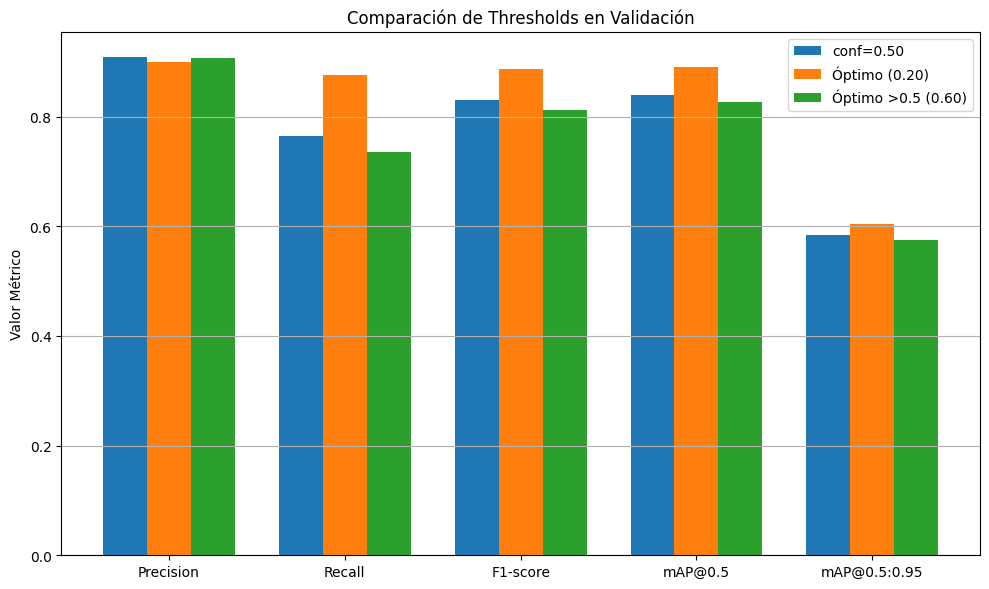

📈 Gráfico guardado en: /content/threshold_analysis_val2/val_threshold_comparison.png


In [5]:
from ultralytics import YOLO
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar modelo y dataset ===
model = YOLO("/content/dataset/resulta_1vs_5_lr0,0001/train/seals/weights/best.pt")
dataset_yaml = "/content/export_yolov8v72_1_vs_5/data.yaml"

# === 2. Configurar rutas de guardado
val_results_dir = "/content/threshold_analysis_val2"
os.makedirs(val_results_dir, exist_ok=True)

# === 3. Evaluar baseline (conf=0.50)
res_05 = model.val(data=dataset_yaml, split="val", conf=0.5, iou=0.5, verbose=False)
p_05, r_05, map50_05, map95_05 = res_05.box.mean_results()
f1_05 = 2 * p_05 * r_05 / (p_05 + r_05) if p_05 + r_05 > 0 else 0

# === 4. Buscar best_conf_global (0.05 a 0.95)
conf_values = [round(i * 0.05, 2) for i in range(1, 20)]
f1s_all, p_all, r_all, m50_all, m95_all = [], [], [], [], []

for conf in conf_values:
    res = model.val(data=dataset_yaml, split="val", conf=conf, iou=0.5, verbose=False)
    p, r, m50, m95 = res.box.mean_results()
    f1 = 2 * p * r / (p + r) if p + r > 0 else 0
    f1s_all.append(f1)
    p_all.append(p)
    r_all.append(r)
    m50_all.append(m50)
    m95_all.append(m95)

best_idx = int(np.argmax(f1s_all))
best_conf_global = conf_values[best_idx]
p_best = p_all[best_idx]
r_best = r_all[best_idx]
map50_best = m50_all[best_idx]
map95_best = m95_all[best_idx]
f1_best = f1s_all[best_idx]

# === 5. Buscar best_conf_high (solo conf > 0.5)
high_start = 11  # para 0.55
conf_values_high = conf_values[high_start:]
f1s_high = f1s_all[high_start:]
p_high = p_all[high_start:]
r_high = r_all[high_start:]
m50_high = m50_all[high_start:]
m95_high = m95_all[high_start:]

best_high_idx = int(np.argmax(f1s_high))
best_conf_high = conf_values_high[best_high_idx]
p_high_best = p_high[best_high_idx]
r_high_best = r_high[best_high_idx]
map50_high_best = m50_high[best_high_idx]
map95_high_best = m95_high[best_high_idx]
f1_high_best = f1s_high[best_high_idx]

# === 6. Crear tabla comparativa
comp_data = {
    "Métrica": ["Precision", "Recall", "F1-score", "mAP@0.5", "mAP@0.5:0.95"],
    "conf=0.50": [p_05, r_05, f1_05, map50_05, map95_05],
    f"conf={best_conf_global:.2f}": [p_best, r_best, f1_best, map50_best, map95_best],
    f"conf>{0.50} (mejor={best_conf_high:.2f})": [p_high_best, r_high_best, f1_high_best, map50_high_best, map95_high_best]
}
df_val_comp = pd.DataFrame(comp_data)

# === 7. Guardar .txt
txt_path = os.path.join(val_results_dir, "val_threshold_comparison.txt")
with open(txt_path, "w") as f:
    f.write("=== COMPARACIÓN DE 3 THRESHOLDS EN VALIDACIÓN ===\n")
    f.write(f"{'Métrica':<15} | {'conf=0.50':^12} | {'Óptimo global':^16} | {'Óptimo > 0.5':^18}\n")
    f.write("-" * 65 + "\n")
    for i in range(len(df_val_comp)):
        m = df_val_comp.loc[i, "Métrica"]
        v1 = df_val_comp.loc[i, "conf=0.50"]
        v2 = df_val_comp.loc[i, f"conf={best_conf_global:.2f}"]
        v3 = df_val_comp.loc[i, f"conf>{0.50} (mejor={best_conf_high:.2f})"]
        f.write(f"{m:<15} | {v1:.4f}      | {v2:.4f}           | {v3:.4f}\n")
print(f"📄 Comparación guardada en: {txt_path}")

# === 8. Guardar .csv
csv_path = os.path.join(val_results_dir, "val_threshold_comparison.csv")
df_val_comp.to_csv(csv_path, index=False)

# === 9. Guardar .md (Markdown)
md_path = os.path.join(val_results_dir, "val_threshold_comparison.md")
with open(md_path, "w") as f:
    f.write(f"| Métrica       | conf = 0.50 | Óptimo global ({best_conf_global:.2f}) | Óptimo > 0.5 ({best_conf_high:.2f}) |\n")
    f.write(f"|---------------|--------------|----------------------|-------------------------|\n")
    for i in range(len(df_val_comp)):
        m = df_val_comp.loc[i, "Métrica"]
        v1 = df_val_comp.loc[i, "conf=0.50"]
        v2 = df_val_comp.loc[i, f"conf={best_conf_global:.2f}"]
        v3 = df_val_comp.loc[i, f"conf>{0.50} (mejor={best_conf_high:.2f})"]
        f.write(f"| {m:<13} | {v1:.4f}       | {v2:.4f}               | {v3:.4f}                  |\n")
print(f"📝 Markdown guardado en: {md_path}")

# === 10. Gráfico de barras
labels = df_val_comp["Métrica"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, df_val_comp["conf=0.50"], width, label="conf=0.50")
ax.bar(x, df_val_comp[f"conf={best_conf_global:.2f}"], width, label=f"Óptimo ({best_conf_global:.2f})")
ax.bar(x + width, df_val_comp[f"conf>{0.50} (mejor={best_conf_high:.2f})"], width, label=f"Óptimo >0.5 ({best_conf_high:.2f})")

ax.set_ylabel("Valor Métrico")
ax.set_title("Comparación de Thresholds en Validación")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis="y")

fig.tight_layout()
plot_path = os.path.join(val_results_dir, "val_threshold_comparison.png")
plt.savefig(plot_path)
plt.show()
print(f"📈 Gráfico guardado en: {plot_path}")


guardar valid

In [9]:
# 10. Guardar los resultados del experimento

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/AWS.v72_seals100i.yolov8/resulta_1vs_5_lr0,0001/val"
!mkdir -p "{dest_folder}"                                                           #El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/threshold_analysis_val2 "{dest_folder}/"   #copiar los reultados del modelo en drive


# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"                                                                 #verifica que los archivos se han copiado correctamente

# Opcional: comprimir la carpeta de resultados para descargarla a tu PC
#!zip -r /content/seals_2025/focas_prueba_snow.zip "{dest_folder}/focas_prueba_snow"   #Aquí se comprime la carpeta que acabas de copiar en Drive (la subcarpeta focas_training_prueba1_640_24_02_25 dentro de foquitas) en un archivo ZIP llamado foquitas.zip que se guarda en /content (la carpeta principal del entorno de Colab).

# Descargar el archivo ZIP a tu PC
#from google.colab import files
#files.download('/content/seals_2025/focas_prueba_snow.zip')

threshold_analysis_val2


test general de yolo

In [17]:
from ultralytics import YOLO

# 1. Cargar el modelo entrenado
model = YOLO("/content/v72_prop1vs5_pruebesitabebe3/seals/weights/best.pt")

# 2. Ejecutar la evaluación sobre el conjunto de test
dataset_yaml = "/content/export_yolov8v72_1_vs_5/data.yaml"

results = model.val(data=dataset_yaml, split="test", conf=0.6, iou=0.50)

# 3. Mostrar las métricas principales
metrics = results.box  # Métricas de bounding boxes

print(f"mAP50:      {metrics.map50:.4f}")
print(f"mAP50-95:   {metrics.map:.4f}")
print(f"Precisión:  {metrics.mp:.4f}")
print(f"Recall:     {metrics.mr:.4f}")

# === TEST POR CLASE ===
# Definir el diccionario de nombres de clase (ajusta según corresponda)
names = {0: 'hole', 1: 'seal'}
# results.box.maps es un array con el mAP (mAP@0.5:0.95) por cada clase
class_maps = metrics.maps

print("\n=== TEST POR CLASE ===")
for cls_map, name in zip(class_maps, names.values()):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")






Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 15.83it/s]


                   all        492         89      0.961      0.551      0.749      0.473
Speed: 0.8ms preprocess, 1.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val26
mAP50:      0.7490
mAP50-95:   0.4732
Precisión:  0.9608
Recall:     0.5506

=== TEST POR CLASE ===
hole: mAP50-95 = 0.4732


guardar test

In [11]:
# 10. Guardar los resultados del experimento

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/AWS.v72_seals100i.yolov8/resulta_1vs_5_lr0,0001/testupdated"
!mkdir -p "{dest_folder}"                                                           #El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/threshold_analysis_test_final "{dest_folder}/"   #copiar los reultados del modelo en drive


# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"                                                                 #verifica que los archivos se han copiado correctamente

# Opcional: comprimir la carpeta de resultados para descargarla a tu PC
#!zip -r /content/seals_2025/focas_prueba_snow.zip "{dest_folder}/focas_prueba_snow"   #Aquí se comprime la carpeta que acabas de copiar en Drive (la subcarpeta focas_training_prueba1_640_24_02_25 dentro de foquitas) en un archivo ZIP llamado foquitas.zip que se guarda en /content (la carpeta principal del entorno de Colab).

# Descargar el archivo ZIP a tu PC
#from google.colab import files
#files.download('/content/seals_2025/focas_prueba_snow.zip')                                             #Este comando abre una ventana de descarga para que puedas bajar el archivo ZIP a tu ordenador.

threshold_analysis_test_final


graficas mejora proceso test

Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1912.1±491.6 MB/s, size: 73.2 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 15.41it/s]


                   all        492         89      0.985      0.753      0.874      0.593
Speed: 0.7ms preprocess, 1.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val49
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1418.3±479.4 MB/s, size: 80.3 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 15.43it/s]


                   all        492         89      0.916      0.854      0.914      0.602
Speed: 0.7ms preprocess, 1.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val50
Ultralytics 8.3.110 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1592.1±925.1 MB/s, size: 56.7 KB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 16.24it/s]


                   all        492         89          1      0.685      0.843      0.579
Speed: 0.7ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val51
📄 Tabla comparativa guardada en: /content/threshold_analysis_test_final/test_threshold_comparison_3thresholds.txt
📝 Markdown guardado en: /content/threshold_analysis_test_final/test_threshold_comparison_3thresholds.md


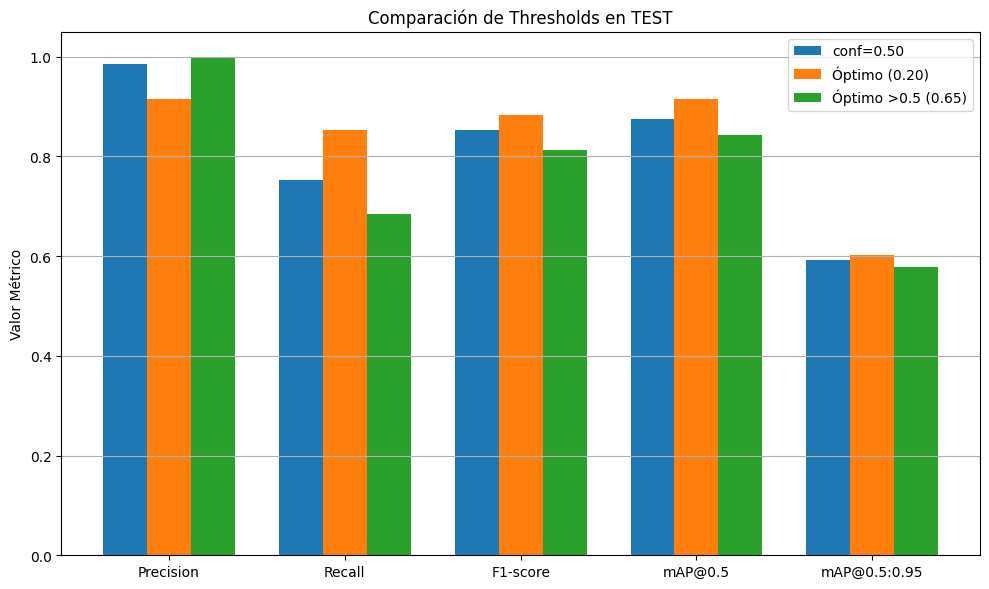

📈 Gráfico guardado en: /content/threshold_analysis_test_final/test_threshold_comparison_3thresholds.png


In [8]:
from ultralytics import YOLO
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Parámetros y configuración ===
model = YOLO("/content/dataset/resulta_1vs_5_lr0,0001/train/seals/weights/best.pt")
dataset_yaml = "/content/export_yolov8v72_1_vs_5/data.yaml"

# Thresholds obtenidos en validación
best_conf_global = 0.20      # ← cámbialo por tu valor real
best_conf_high = 0.65        # ← cámbialo por tu valor real > 0.5

# Carpeta para guardar resultados
test_results_dir = "/content/threshold_analysis_test_final"
os.makedirs(test_results_dir, exist_ok=True)

# === 2. Evaluación con conf = 0.50 ===
res_05 = model.val(data=dataset_yaml, split="test", conf=0.5, iou=0.5, verbose=False)
p_05, r_05, map50_05, map95_05 = res_05.box.mean_results()
f1_05 = 2 * p_05 * r_05 / (p_05 + r_05) if p_05 + r_05 > 0 else 0

# === 3. Evaluación con best_conf_global ===
res_global = model.val(data=dataset_yaml, split="test", conf=best_conf_global, iou=0.5, verbose=False)
p_g, r_g, map50_g, map95_g = res_global.box.mean_results()
f1_g = 2 * p_g * r_g / (p_g + r_g) if p_g + r_g > 0 else 0

# === 4. Evaluación con best_conf_high ===
res_high = model.val(data=dataset_yaml, split="test", conf=best_conf_high, iou=0.5, verbose=False)
p_h, r_h, map50_h, map95_h = res_high.box.mean_results()
f1_h = 2 * p_h * r_h / (p_h + r_h) if p_h + r_h > 0 else 0

# === 5. Crear DataFrame comparativo
comp_data = {
    "Métrica": ["Precision", "Recall", "F1-score", "mAP@0.5", "mAP@0.5:0.95"],
    "conf=0.50": [p_05, r_05, f1_05, map50_05, map95_05],
    f"conf={best_conf_global:.2f}": [p_g, r_g, f1_g, map50_g, map95_g],
    f"conf>{0.50} (mejor={best_conf_high:.2f})": [p_h, r_h, f1_h, map50_h, map95_h]
}
df_test_comp = pd.DataFrame(comp_data)

# === 6. Guardar .txt
txt_path = os.path.join(test_results_dir, "test_threshold_comparison_3thresholds.txt")
with open(txt_path, "w") as f:
    f.write("=== COMPARACIÓN DE 3 THRESHOLDS EN TEST ===\n")
    f.write(f"{'Métrica':<15} | {'conf=0.50':^12} | {'Óptimo global':^16} | {'Óptimo > 0.5':^18}\n")
    f.write("-" * 65 + "\n")
    for i in range(len(df_test_comp)):
        m = df_test_comp.loc[i, "Métrica"]
        v1 = df_test_comp.loc[i, "conf=0.50"]
        v2 = df_test_comp.loc[i, f"conf={best_conf_global:.2f}"]
        v3 = df_test_comp.loc[i, f"conf>{0.50} (mejor={best_conf_high:.2f})"]
        f.write(f"{m:<15} | {v1:.4f}      | {v2:.4f}           | {v3:.4f}\n")
print(f"📄 Tabla comparativa guardada en: {txt_path}")

# === 7. Guardar .csv
csv_path = os.path.join(test_results_dir, "test_threshold_comparison_3thresholds.csv")
df_test_comp.to_csv(csv_path, index=False)

# === 8. Guardar .md (Markdown)
md_path = os.path.join(test_results_dir, "test_threshold_comparison_3thresholds.md")
with open(md_path, "w") as f:
    f.write(f"| Métrica       | conf = 0.50 | Óptimo global ({best_conf_global:.2f}) | Óptimo > 0.5 ({best_conf_high:.2f}) |\n")
    f.write(f"|---------------|--------------|----------------------|-------------------------|\n")
    for i in range(len(df_test_comp)):
        m = df_test_comp.loc[i, "Métrica"]
        v1 = df_test_comp.loc[i, "conf=0.50"]
        v2 = df_test_comp.loc[i, f"conf={best_conf_global:.2f}"]
        v3 = df_test_comp.loc[i, f"conf>{0.50} (mejor={best_conf_high:.2f})"]
        f.write(f"| {m:<13} | {v1:.4f}       | {v2:.4f}               | {v3:.4f}                  |\n")
print(f"📝 Markdown guardado en: {md_path}")

# === 9. Gráfico de barras
labels = df_test_comp["Métrica"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, df_test_comp["conf=0.50"], width, label="conf=0.50")
ax.bar(x, df_test_comp[f"conf={best_conf_global:.2f}"], width, label=f"Óptimo ({best_conf_global:.2f})")
ax.bar(x + width, df_test_comp[f"conf>{0.50} (mejor={best_conf_high:.2f})"], width, label=f"Óptimo >0.5 ({best_conf_high:.2f})")

ax.set_ylabel("Valor Métrico")
ax.set_title("Comparación de Thresholds en TEST")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis="y")

fig.tight_layout()
plot_path = os.path.join(test_results_dir, "test_threshold_comparison_3thresholds.png")
plt.savefig(plot_path)
plt.show()
print(f"📈 Gráfico guardado en: {plot_path}")


test para sacar clases

=== MÉTRICAS GENERALES SOBRE TEST ===
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 15.74it/s]


                   all        492         89      0.937      0.663      0.797      0.493
Speed: 0.6ms preprocess, 1.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val27
Precision promedio: 0.9365
Recall promedio: 0.6629
mAP@0.5: 0.7965
mAP@0.5:0.95: 0.4929

=== MÉTRICAS POR CLASE EN TEST ===
hole: mAP50-95 = 0.4929

=== CURVA DE MÉTRICAS SEGÚN CONFIDENCE (TEST) ===
Evaluando con conf = 0.05
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 14.92it/s]


                   all        492         89      0.848      0.876      0.878      0.532
Speed: 0.7ms preprocess, 1.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val28
Evaluando con conf = 0.1
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 15.18it/s]


                   all        492         89      0.856      0.865      0.874       0.53
Speed: 0.7ms preprocess, 1.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val29
Evaluando con conf = 0.15
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 14.94it/s]


                   all        492         89      0.862      0.843      0.864      0.525
Speed: 0.7ms preprocess, 1.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val30
Evaluando con conf = 0.2
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 14.71it/s]


                   all        492         89       0.86      0.831      0.859      0.525
Speed: 0.7ms preprocess, 1.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val31
Evaluando con conf = 0.25
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 14.95it/s]


                   all        492         89      0.859       0.82      0.854      0.523
Speed: 0.7ms preprocess, 1.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val32
Evaluando con conf = 0.3
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 14.88it/s]


                   all        492         89      0.855      0.798      0.844       0.52
Speed: 0.8ms preprocess, 1.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val33
Evaluando con conf = 0.35
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 15.31it/s]


                   all        492         89      0.859      0.753      0.825      0.508
Speed: 0.7ms preprocess, 1.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val34
Evaluando con conf = 0.4
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 14.84it/s]


                   all        492         89      0.917      0.685      0.801      0.497
Speed: 0.8ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val35
Evaluando con conf = 0.45
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 15.14it/s]


                   all        492         89      0.912      0.697      0.808      0.499
Speed: 0.8ms preprocess, 1.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val36
Evaluando con conf = 0.5
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 15.60it/s]


                   all        492         89      0.937      0.663      0.797      0.493
Speed: 0.8ms preprocess, 1.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val37
Evaluando con conf = 0.55
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:02<00:00, 15.15it/s]


                   all        492         89      0.931      0.607      0.769      0.482
Speed: 0.7ms preprocess, 1.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val38
Evaluando con conf = 0.6
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 16.13it/s]


                   all        492         89      0.961      0.551      0.749      0.473
Speed: 0.8ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val39
Evaluando con conf = 0.65
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 16.24it/s]


                   all        492         89      0.939      0.348       0.64      0.424
Speed: 0.7ms preprocess, 1.4ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val40
Evaluando con conf = 0.7
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 16.97it/s]


                   all        492         89        0.9      0.101      0.506      0.365
Speed: 0.8ms preprocess, 1.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val41
Evaluando con conf = 0.75
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 17.00it/s]


                   all        492         89          0          0          0          0
Speed: 1.2ms preprocess, 1.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val42
Evaluando con conf = 0.8
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 16.48it/s]


                   all        492         89          0          0          0          0
Speed: 1.1ms preprocess, 1.6ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val43
Evaluando con conf = 0.85
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 16.54it/s]


                   all        492         89          0          0          0          0
Speed: 1.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val44
Evaluando con conf = 0.9
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 17.12it/s]


                   all        492         89          0          0          0          0
Speed: 1.0ms preprocess, 1.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val45
Evaluando con conf = 0.95
Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/export_yolov8v72_1_vs_5/test/labels.cache... 492 images, 410 backgrounds, 0 corrupt: 100%|██████████| 492/492 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:01<00:00, 17.01it/s]


                   all        492         89          0          0          0          0
Speed: 1.2ms preprocess, 1.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val46


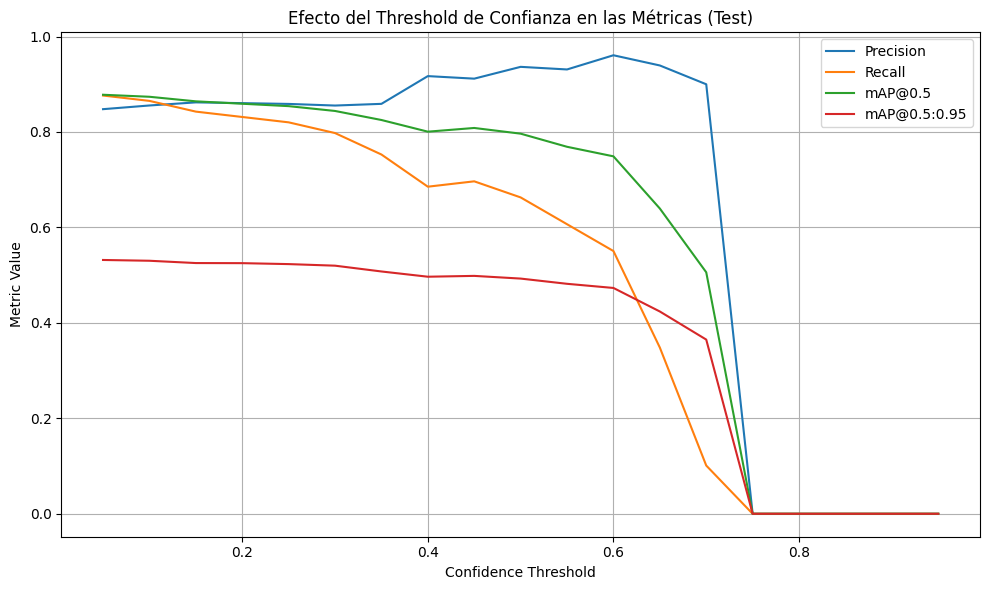

In [18]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# === 1. Cargar el modelo entrenado ===
model = YOLO("/content/v72_prop1vs5_pruebesitabebe3/seals/weights/best.pt")

# === 2. Definir ruta del dataset con división de test ===
dataset_yaml = "/content/export_yolov8v72_1_vs_5/data.yaml"  # Debe tener la división 'test' definida

# === 3. Evaluar el modelo sobre el conjunto de test ===
print("=== MÉTRICAS GENERALES SOBRE TEST ===")
results = model.val(data=dataset_yaml, split="test", conf=0.5, iou=0.50)  # Ajusta conf e iou si lo necesitas

# === 4. Métricas globales ===
# Accedemos directamente a los atributos en lugar de llamarlos como funciones
print(f"Precision promedio: {results.box.mp:.4f}")
print(f"Recall promedio: {results.box.mr:.4f}")
print(f"mAP@0.5: {results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {results.box.map:.4f}")

# === 5. Métricas por clase ===
print("\n=== MÉTRICAS POR CLASE EN TEST ===")
# Define manualmente el diccionario de nombres de clase (ajusta según corresponda)
names = {0: 'hole', 1: 'seal'}
# results.box.maps es un array con el mAP (mAP@0.5:0.95) por cada clase
class_maps = results.box.maps
for cls_map, name in zip(class_maps, names.values()):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")

# === 6. Curva de métricas según confidence threshold ===
conf_values = [round(i * 0.05, 2) for i in range(1, 20)]  # De 0.05 a 0.95
precisions = []
recalls = []
maps50 = []
maps_val = []

print("\n=== CURVA DE MÉTRICAS SEGÚN CONFIDENCE (TEST) ===")
for conf in conf_values:
    print(f"Evaluando con conf = {conf}")
    res = model.val(data=dataset_yaml, split="test", conf=conf, iou=0.5, verbose=False)
    # Accedemos directamente a los atributos
    precisions.append(res.box.mp)
    recalls.append(res.box.mr)
    maps50.append(res.box.map50)
    maps_val.append(res.box.map)

# === 7. Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(conf_values, precisions, label="Precision")
plt.plot(conf_values, recalls, label="Recall")
plt.plot(conf_values, maps50, label="mAP@0.5")
plt.plot(conf_values, maps_val, label="mAP@0.5:0.95")
plt.xlabel("Confidence Threshold")
plt.ylabel("Metric Value")
plt.title("Efecto del Threshold de Confianza en las Métricas (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
